# Bootstrapping

## Dataset

In [ ]:
# Set a seed for reproducibility
torch.manual_seed(0)

# Generate dataset and grid
X = torch.rand(100, 1) * 0.5
x_grid = torch.linspace(-5, 5, 1000).reshape(-1, 1)

# Define function
def target_toy(x, seed):
    torch.manual_seed(seed)
    epsilons = torch.randn(3) * 0.02
    return (
        x + 0.3 * torch.sin(2 * torch.pi * (x + epsilons[0])) +
        0.3 * torch.sin(4 * torch.pi * (x + epsilons[1])) + epsilons[2]
    )

# Generate target values with different seeds
Y = torch.stack([target_toy(x, seed) for x, seed in zip(X, range(X.shape[0]))])

## Model

In [ ]:
class GenericNet(nn.Module):
    def __init__(self, input_dim):
        super(GenericNet, self).__init__()
        self.input_dim = input_dim
        
        self.net = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=16),
            nn.ELU(),
            nn.Linear(in_features=16, out_features=16),
            nn.ELU(),
            nn.Linear(in_features=16, out_features=1)
        )
        # Additional layers can be added here based on the architecture
        # Apply Xavier uniform initialization to the weights
        self.init_weights(self.net)

    def forward(self, x):
        return self.net(x)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

## Training

In [ ]:
import push.bayes.ensemble
# Combine X and Y into a TensorDataset
dataset = TensorDataset(X, Y)

# Create a DataLoader for batch processing during training
batch_size = 100  # Adjust according to your needs
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


num_ensembles=9
epochs=3000
lr = 0.03

boot_ensemble = push.bayes.ensemble.train_deep_ensemble(
        train_loader,
        torch.nn.MSELoss(),
        epochs,
        GenericNet, 1,
        lr=lr,
        num_devices=2,
        num_ensembles=num_ensembles,
        bootstrap=True
    )

  0%|          | 0/3000 [00:00<?, ?it/s, loss=tensor(0.0368)]

100%|██████████| 3000/3000 [02:24<00:00, 20.70it/s, loss=tensor(0.0026)]


##### Inference


In [ ]:
boot_ensemble_output = ensemble.posterior_pred(x_grid, f_reg=True, mode=["mean", "std", "pred"])

##### Visualization

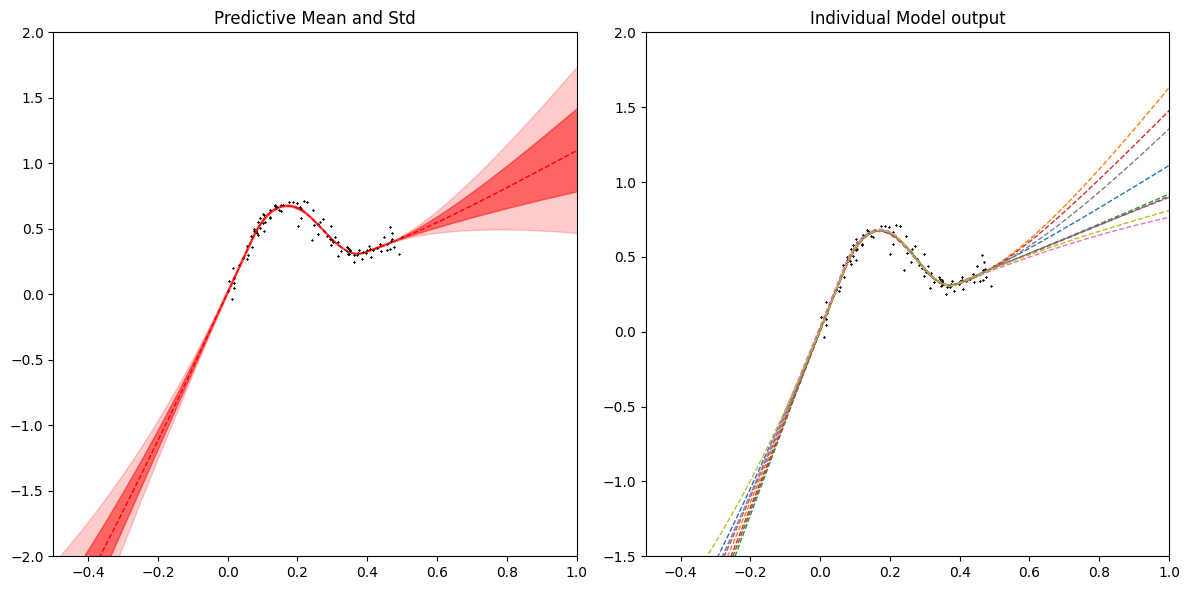

In [ ]:
plot_toy(boot_ensemble_output, num_ensembles)

[1] Kevin Murphy. Probabilistic Machine Learning Advanced Topics. Chapter 17. The MIT Press: Adaptive computation and machine learning series (2023). Cambridge, Massachusetts.
